# Setup

## Installs

In [1]:
# Segmentation
# ! pip install --upgrade mxnet
# ! pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install --upgrade gluoncv

# Edge detection
# ! conda install scikit-image

# Depth estimation
# ! pip install -q transformers

## Imports

In [2]:
# Segmentation
import numpy as np
import mxnet as mx
from mxnet import image as mimage
import gluoncv
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as pil
ctx = mx.cpu(0) # using cpu

# Edge detection
from matplotlib import cm

# Depth estimation
from transformers import pipeline
import cv2
from scipy.signal import savgol_filter

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\gluoncv\__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.6.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [3]:
# Import custom methods
import general_methods
import edge_detection
import depth_estimation

# Read input image File

In [4]:
filename = 'images/inputs/rooms/real/empty-room.png'

In [5]:
# Open image with PIL and resave to smaller size if needed (to stop CPU error)
input_img = pil.open(filename)
input_img.thumbnail((1000, 1000))
input_img.save(filename)

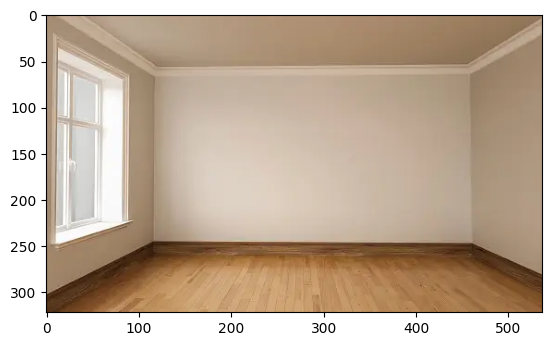

In [6]:
input_img = mimage.imread(filename)
plt.imshow(input_img.asnumpy())
plt.show()

# Semantic Segmentation

In [7]:
# Get pre-trained segmentation model and save to var
psp_resnet101_ade = gluoncv.model_zoo.get_psp_resnet101_ade(pretrained=True)

self.crop_size 480


In [8]:
# Transform image
img_t = gluoncv.data.transforms.presets.segmentation.test_transform(input_img, ctx)

# Use model to get prediction of segmentation labels
output = psp_resnet101_ade.predict(img_t)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = gluoncv.utils.viz.get_color_pallete(predict, 'ade20k')
mask.save('images/outputs/segmentation-output.png')

In [9]:
# Read segmentation image back in as a matplotlib image
mmask = mpimg.imread('images/outputs/segmentation-output.png')
# plt.imshow(mmask)
# plt.show()

### Isolate walls

In [10]:
labels = general_methods.get_labels_string(mmask)

In [11]:
# Save the indices of every pixel that isn't part of the walls
other_x, other_y = np.where(labels != "0.47058824,0.47058824,0.47058824,1.0")
# Save the indices of every pixel that is part of the walls
walls_x, walls_y = np.where(labels == "0.47058824,0.47058824,0.47058824,1.0")

In [12]:
# Make copy of image and set the indices of everything but the walls to black
input_copy = input_img.copy().asnumpy()
input_copy = input_copy.astype(float)
input_copy[other_x, other_y] = np.array([0, 0, 0], dtype=float)
input_copy = np.clip(input_copy, 0, 255)

segmented_input = pil.fromarray(input_copy.astype(np.uint8))
segmented_input.save('images/outputs/segmentation-walls-only.png')

# plt.imshow(segmented_input)
# plt.show()

# Depth Estimation

In [13]:
# Predict depth and save output
input_pil = pil.open(filename)

depth_image = depth_estimation.estimate_depth(input_pil)

plt.imsave('images/outputs/depth-output.png', depth_image)

# Edge Detection

In [14]:
# Use canny edge detection
input_cv2 = cv2.imread(filename)
# edges = edge_detection.detect_edges(input_cv2)
blur = cv2.blur(input_cv2, (3, 3)) # Add blur
gray = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY) # Convert image to grayscale
edges = cv2.Canny(gray,15,50,apertureSize=3) # Use canny method

edge_map = pil.fromarray(edges)
edge_map.save('images/outputs/edge-detection-output.png')

In [15]:
# Combine edge map and segmentation map
edge_map_array = np.asarray(edge_map.convert('RGB'))
segmented_edges = np.empty( (edge_map_array.shape[0], edge_map_array.shape[1], 3) )
segmented_edges[:] = np.nan
segmented_edges[walls_x, walls_y] = edge_map_array[walls_x, walls_y]
segmented_edges = segmented_edges.astype(dtype=np.uint8)

pil.fromarray(segmented_edges).save('images/outputs/segmented-edges.png')

# Finding corners

### Hough transform

In [16]:
# Hough transform on segmented edges
hough_img = edge_detection.hough_transform(segmented_edges)
cv2.imwrite('images/outputs/hough-output.png', hough_img)

True

In [17]:
# Get vertical lines only - https://www.youtube.com/watch?v=veoz_46gOkc
kernel = np.ones((20,1), np.uint8)
vertical_lines = cv2.erode(hough_img, kernel, iterations=1)
cv2.imwrite('images/outputs/hough_corners.png', vertical_lines)

True

In [18]:
hough_corners = []
corners = plt.imread('images/outputs/hough_corners.png')[:, :, :3] * 255
colours = general_methods.get_labels_string(corners)

# Find indices where there is colour
_, hough_corners = np.where(colours == "255.0,0.0,0.0")

### Depth change to find corners

In [19]:
# Find the mean depth for each column (1px wide) in the wall depth map and plot
test_depth = np.array(depth_image).copy().astype(float)
test_depth[other_x, other_y] = np.nan

mean_depth = np.nanmean(test_depth, axis=0)
# plt.plot(mean_depth)
# plt.show()

In [20]:
# Smooth using savgol filter
mean_depth = savgol_filter(mean_depth, 51, 3) # window size 51, polynomial order 3
# plt.plot(mean_depth)
# plt.show()

In [21]:

savgol_corners = depth_estimation.savgol_corners(mean_depth)

#### Harris corner detection

In [22]:
# Create matrix/image of mean depth graph
matrix = general_methods.get_matrix(mean_depth)
matrix = matrix.astype(np.uint8)

pil.fromarray(matrix).save("images/outputs/matrix.png")

In [23]:
# Use cv2 method to detect 'corners'
matrix_corners = depth_estimation.harris_corners(matrix)

pil.fromarray(matrix_corners.astype(np.uint8)).save("images/outputs/corners.png")

In [24]:
harris_corners = []

colours = general_methods.get_labels_string(matrix_corners)

# Find indices where there is red
_, harris_corners = np.where(colours == "255,0,0")

### Combing corner detection methods

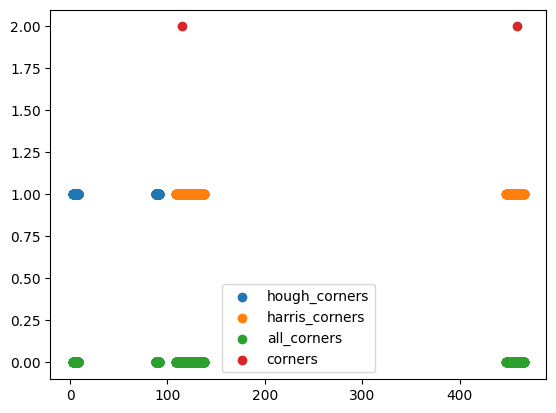

In [25]:
plt.scatter(hough_corners, [1]*len(hough_corners), label='hough_corners')
plt.scatter(harris_corners, [1]*len(harris_corners), label='harris_corners')

all_corners = np.concatenate((hough_corners, harris_corners))
plt.scatter(all_corners, np.zeros(len(all_corners)), label='all_corners')

# Find only most dense clusters
from sklearn.cluster import DBSCAN

# clf = DBSCAN(eps=20, min_samples=500).fit(all_corners.reshape(-1, 1))
clf = DBSCAN(eps=20, min_samples=(all_corners.size/4)).fit(all_corners.reshape(-1, 1))

# Find centers of clusters by taking means
centers = []
for i in (np.unique(clf.labels_)):
    if i != -1:
        ind = np.where(clf.labels_ == i)
        ind = all_corners[ind]
        centers.append(np.mean(ind))

centers = np.round(centers, 0)
corner_inds = centers.astype(int)

plt.scatter(centers, [2]*len(centers), label='corners')
plt.legend()
plt.show()

##### Combining angles and prediction difference

In [26]:
only_walls = np.array(segmented_input.copy())
only_walls[other_x, other_y] = [0, 0, 0]
only_walls[walls_x, walls_y] = [255, 255, 255]
only_walls[:, corner_inds] = [0, 0, 0]

pil_image = pil.fromarray(only_walls)
pil_image.save("images/outputs/segmented-with-corners.png")

## Finding Geometry

##### Extracting Geometry

In [27]:
only_walls_grey = cv2.cvtColor(only_walls, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(only_walls_grey, 0, 1, 0)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

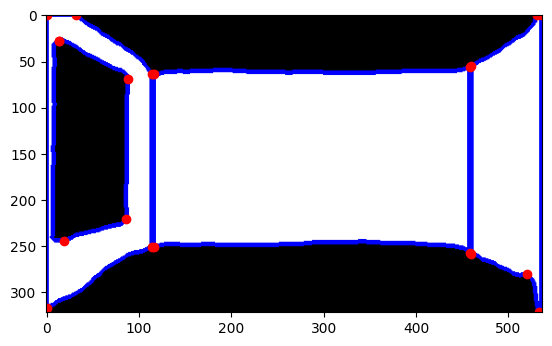

In [28]:
only_walls_copy = only_walls.copy()
final_cnt = []

for cnt in contours:
    x1,y1 = cnt[0][0]
    approx = cv2.approxPolyDP(cnt, 0.03*cv2.arcLength(cnt, True), False)
    only_walls_copy = cv2.drawContours(only_walls_copy, [cnt], -1, (0,0,255), 3)
    plt.scatter(approx[:, 0, 0], approx[:, 0, 1], color="r")
    final_cnt.append(approx[:, 0, :])
    
plt.imshow(only_walls_copy)
final_cnt = np.array(final_cnt, dtype=object)

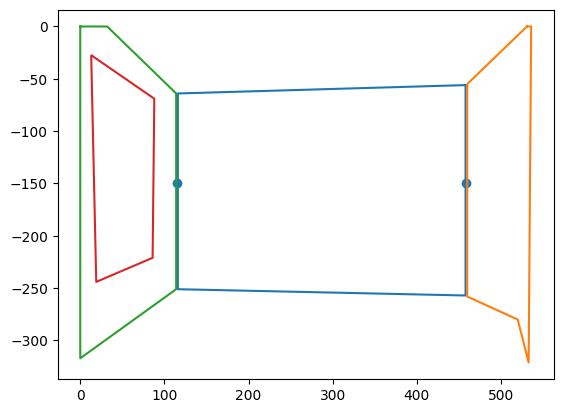

In [29]:
# Plot the found contours
for i in range(len(final_cnt)):
    data = np.append(final_cnt[i], final_cnt[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])
    
plt.scatter(corner_inds, [-150]*len(corner_inds))

<class 'numpy.intc'>
<class 'numpy.intc'>
<class 'numpy.intc'>
<class 'numpy.intc'>


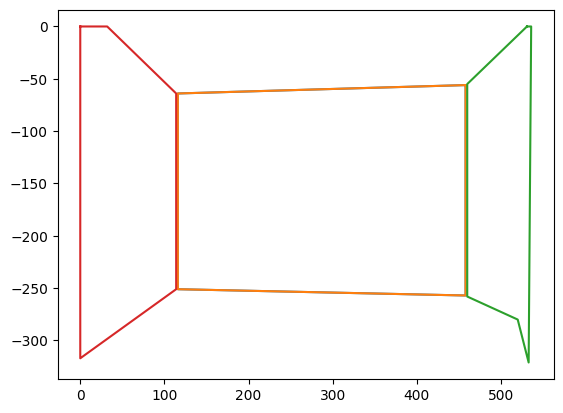

In [30]:
# Keep only shapes which have at least one point on the corner wall

corner_adj_geom = []

for i in range(len(final_cnt)):
    data = np.array(final_cnt[i])[:, 0]
    limit = 5
    
    for ind in corner_inds:
        diff = np.sum(np.abs(data.copy() - ind) <= limit)
        if diff >= 1:
            print(type(final_cnt[i][0][0]))
            corner_adj_geom.append(final_cnt[i])

# Plot contours
for i in range(len(corner_adj_geom)):
    data = np.append(corner_adj_geom[i], corner_adj_geom[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])



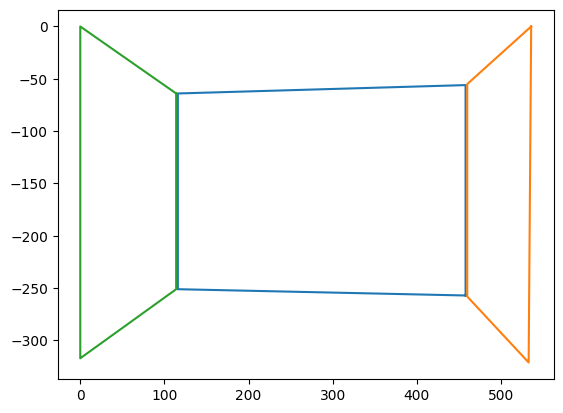

In [31]:
geom = []

# for each shape
for i in range(len(corner_adj_geom)):
    # try multiple thresholds
    for j in np.linspace(0.01, 0.1):
        # find convex hull
        convex_hull = cv2.convexHull(corner_adj_geom[i])
        # calc the polygon
        convex_hull = cv2.approxPolyDP(convex_hull, j*cv2.arcLength(convex_hull, True), True)

        # if polygon has length of 4, keep it and break loop
        if len(convex_hull) == 4:
            convex_hull = convex_hull.reshape((4,2))

            temp_0 = convex_hull[0][0]
            temp_1 = convex_hull[1][0]
            temp_2 = convex_hull[2][0]
            temp_3 = convex_hull[3][0]
            biggest, smallest = [], []

            for ind1 in range(0,4):
                for ind2 in range(0,4):
                    if (abs(convex_hull[ind1][0] - convex_hull[ind2][0]) <= 150) and (convex_hull[ind1][0] != convex_hull[ind2][0]):
                        biggest.append(max(convex_hull[ind1][0], convex_hull[ind2][0]))
                        smallest.append(min(convex_hull[ind1][0], convex_hull[ind2][0]))
                        convex_hull[ind1][0] = biggest[-1]
                        convex_hull[ind2][0] = biggest[-1]

            count = 0
            left = set()

            for x in range(0,4):
                for y in range(0,4):
                    if abs(convex_hull[x][0] - convex_hull[y][0]) <= 20:
                        count += 1
                    if convex_hull[x][0] < convex_hull[y][0]: # find which is the left side of the wall
                        left.add(x)

            if len(smallest) > 0:
                for x in range(0,4):
                    if x in left and convex_hull[x][0] in biggest:
                        convex_hull[x][0] = min(smallest)

            if count > 8:
                convex_hull[0][0] = temp_0
                convex_hull[1][0] = temp_1
                convex_hull[2][0] = temp_2
                convex_hull[3][0] = temp_3

            geom.append(convex_hull)
            break

new_geom = []

if len(geom) > 0:
    # Remove any duplicate walls
    new_geom = [geom[0]]

    for i in geom:
        # print(i)
        seen = False
        for j in new_geom:
            if np.array_equal(i, j):
                seen = True
                break
        
        if seen == False:
            new_geom.append(i)


# Plot new contours
for i in range(len(new_geom)):
    data = np.append(new_geom[i], new_geom[i][0]).reshape(-1, 2)
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])

plt.savefig('images/outputs/final-contours.png')

In [32]:
# Remove contours below a certain size
area1 = cv2.contourArea(new_geom[0])
print(area1)

66348.0


## Perspective Transformation

In [33]:
wallpaper = cv2.imread('images/inputs/wallpaper/check.jpg')

### Transform wallpaper pattern

In [34]:
# find coordinates of corners of wallpaper image
shape = wallpaper.shape
# corners = np.float32([[0,0], [0, shape[0]], [shape[1], shape[0]], [shape[1],0]])

# get size of output image
height = input_cv2.shape[0]
width = input_cv2.shape[1]
size = (width, height)

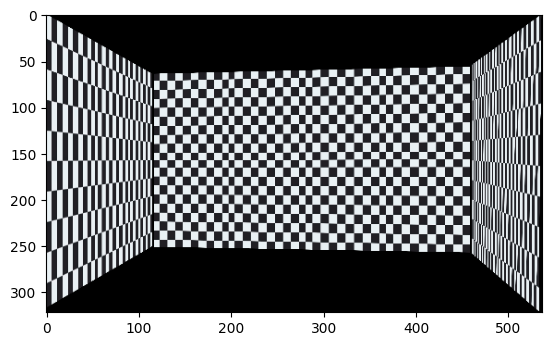

In [44]:
walls_1, walls_2 = [], []
input_corners = np.float32([[0,0], [0, height], [width, height], [width,0]])

if len(new_geom) > 0:
    # Find and perform transform for each wall
    for wall in range(len(new_geom)):
        wall_coords = np.float32(new_geom[wall])

        x_coords = set()
        for i in wall_coords:
            x_coords.add(i[0])
        x_coords = list(x_coords)
        if len(x_coords) >= 2:
            x = abs(x_coords[0] - x_coords[1])
        else:
            x = 0

        y_coords = set()
        for i in wall_coords:
            y_coords.add(i[1])
        y_coords = list(y_coords)
        y = abs(max(y_coords) - min(y_coords))

        # Tile the wallpaper
        tiled = np.tile(wallpaper,(max(int(x//80), 1), max(int(y//80), 1), 1))
        corners = np.float32([[0,0], [0, tiled.shape[0]], [tiled.shape[1], tiled.shape[0]], [tiled.shape[1],0]])
        
        # Get and apply perspective transform
        matrix = cv2.getPerspectiveTransform(corners, wall_coords)
        temp_result = cv2.warpPerspective(tiled, matrix, size)

        walls_1.append(temp_result)

# Tile the wallpaper
tiled = np.tile(wallpaper,(height//80,width//80,1))
corners = np.float32([[0,0], [0, tiled.shape[0]], [tiled.shape[1], tiled.shape[0]], [tiled.shape[1],0]])
# Get and apply perspective transform
matrix = cv2.getPerspectiveTransform(corners, input_corners)
temp_result = cv2.warpPerspective(tiled, matrix, size)
walls_2.append(temp_result)

result_2 = np.sum(walls_2, axis=0)

if len(walls_1) < 1:
    result_1 = result_2
else:
    result_1 = np.sum(walls_1, axis=0)


plt.imshow(result_1)
plt.savefig('images/outputs/wallpaper.png')
plt.show()

### Combine transformed wallpaper with original image

In [37]:
# new wall indices
geom_mask = []

# Create mask of wall edges from contours by setting the walls to 1 and everything else to 0
for contour in new_geom:
    single_contour_mask = []
    for i in range(height):
        row = []
        for j in range(width):
            # For each point, check if it is within (or on boundary of) the current contour, and set to 1 if it is
            t = cv2.pointPolygonTest(contour, tuple([j, i]), False)
            if t in [1, 0]:
                row.append(1)
            else:
                row.append(0)      
        single_contour_mask.append(row)
    single_contour_mask = np.array(single_contour_mask)
    # Add current contour to the overall mask of the geometry
    geom_mask.append(single_contour_mask)

if len(geom_mask) > 0:
    geom_mask = np.amax(geom_mask, axis=0)

In [38]:
# Create mask of walls by setting the walls to 1 and everything else to 0
wall_mask = np.zeros([height, width])
wall_mask[walls_x, walls_y] = 1

if len(geom_mask) > 0:
    # Combine masks by only taking the points where both masks overlap
    final_mask = np.zeros([height, width])

    for i in range(height):
        for j in range(width):
            if wall_mask[i,j] + geom_mask[i,j] == 2:
                final_mask[i,j] = 1


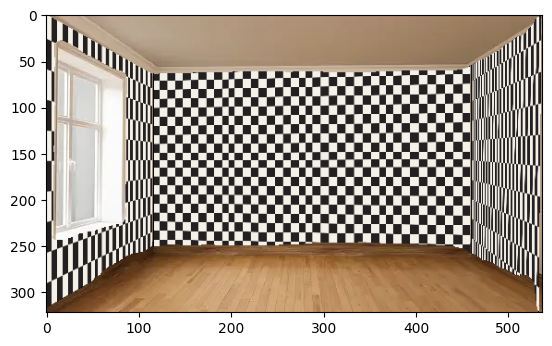

In [39]:
# Create final image by setting mask indices to the wallpaper result produced earlier
final_output = input_cv2.copy()
final_output_2 = input_cv2.copy()

if len(geom_mask) > 0:
    mask_other_x, mask_other_y = np.where(final_mask == 1)
    final_output[mask_other_x, mask_other_y] = result_1[mask_other_x, mask_other_y]

final_output_2[walls_x, walls_y] = result_2[walls_x, walls_y]

cv2.imwrite("images/outputs/final-outputs/output.png", final_output)
cv2.imwrite("images/outputs/final-outputs/simple-output.png", final_output_2)

plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB))